#Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Install libraries and packages

In [ ]:
%%capture
!pip install tensorflow keras numpy opencv-python matplotlib pandas visualkeras pathlib

#Import libraries

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
import keras
import pandas as pd
import os   #navigate in data directory, folder structure
import imghdr
import pathlib
import visualkeras

# MODEL1 (DenseNet)

##Load images (crack, no_crack)

In [ ]:
root_path='path/to/root'
no_crack_path = 'path/to/no-crack'
crack_path = 'path/to/crack'

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(root_path)

Found 8419 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator() #we can access the data pipeline

In [ ]:
batch = data_iterator.next() #batch contains 2 parts: images, labels

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

##Scale the image data

In [ ]:
batch[0].min()

0.0

In [ ]:
batch[0].max()

255.0

In [ ]:
scaled = batch[0]/255    #scaled from 0 to 1
scaled.max()

1.0

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

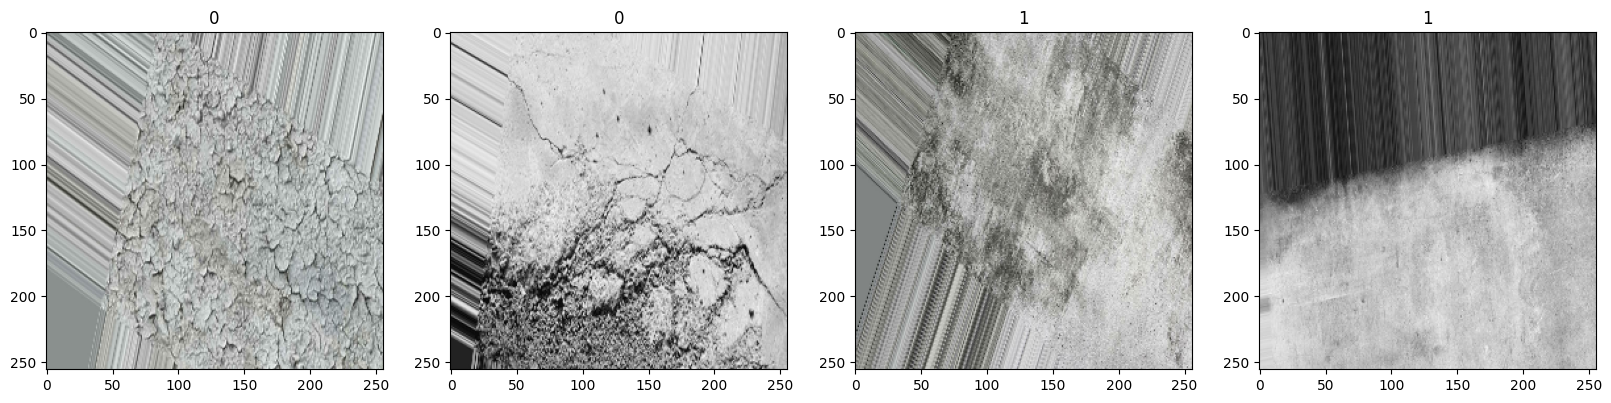

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

##Split the images into training and testing sets

In [ ]:
len(data)

264

In [ ]:
train_size1 = int(len(data)*.7)
val_size1 = int(len(data)*.2) +1 #evaluation of model
test_size1 = int(len(data)*.1) + 1 #testing model
print(train_size1, val_size1, test_size1)

184 53 27


In [ ]:
train_data1 = data.take(train_size1)
val_data1 = data.skip(train_size1).take(val_size1)
test_data1= data.skip(train_size1 + val_size1).take(test_size1)

##Developing DenseNet model

In [ ]:
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D,GlobalAveragePooling2D,Dense,Dropout,Conv2D

In [ ]:
base_model = DenseNet201(
    input_shape=(256,256,3),
    weights='imagenet',
    include_top=False)

#Freeze the first 10 layers
for layer in base_model.layers[:10]:
      layer.trainable =False


x=base_model.output


#x=Conv2D(128,3,3),activation='relu')(x)


#on the top of the model we add  the layers below:
x = GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.3)(x)

predictions=Dense(2,activation='sigmoid')(x)  # 2 neurons - because we have 2 classes (crack, no_crack) on the first level

model1=Model(inputs=base_model.inputs, outputs=predictions)

74836368/74836368 [==============================] - 3s 0us/step


##Compiling DenseNet model

In [ ]:
model1.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'])

##Fitting MODEL1

In [ ]:
history1=model1.fit(
    train_data1,
    validation_data=val_data1,
    epochs=100,
    verbose=1
)

##Plot performance

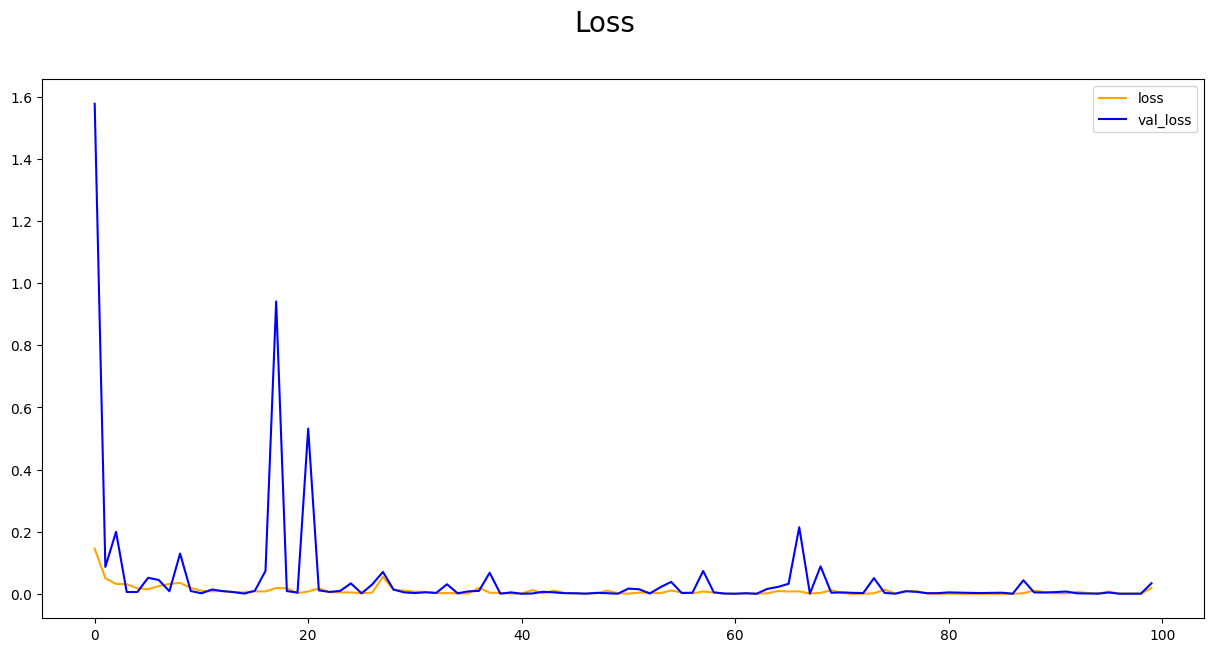

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(history1.history['loss'], color = 'orange', label = 'loss')
plt.plot(history1.history['val_loss'], color = 'blue', label = 'val_loss')
fig.suptitle ('Loss', fontsize = 20)
plt.legend()
plt.show()

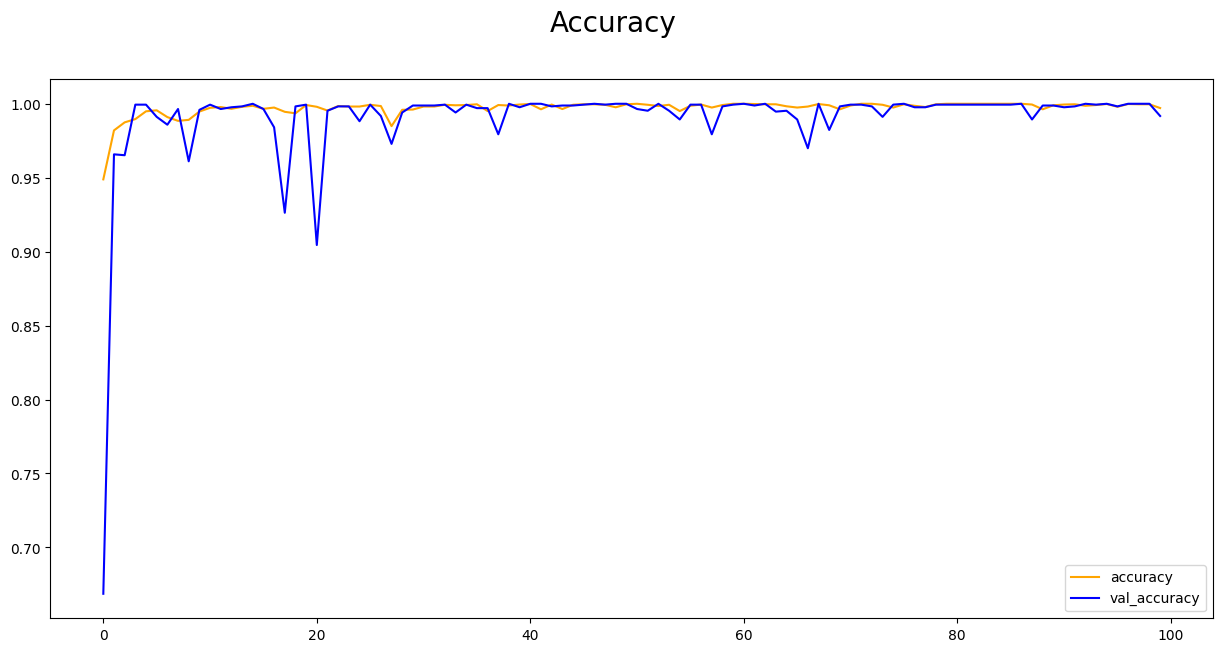

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(history1.history['accuracy'], color = 'orange', label = 'accuracy')
plt.plot(history1.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
fig.suptitle ('Accuracy', fontsize = 20)
plt.legend()
plt.show()

##Saving MODEL1

In [ ]:
model1.save('path/to/model')

#MODEL2 (InceptionV3)

##Load images (delamination, spalling, surface_crack)

In [ ]:
crack_path = 'path/to/crack'

In [ ]:
crack_data = tf.keras.utils.image_dataset_from_directory(crack_path)

Found 6651 files belonging to 3 classes.


In [ ]:
crack_data_iterator = crack_data.as_numpy_iterator() #we can access the data pipeline

In [ ]:
crack_batch = crack_data_iterator.next() #batch contains 2 parts: images, labels

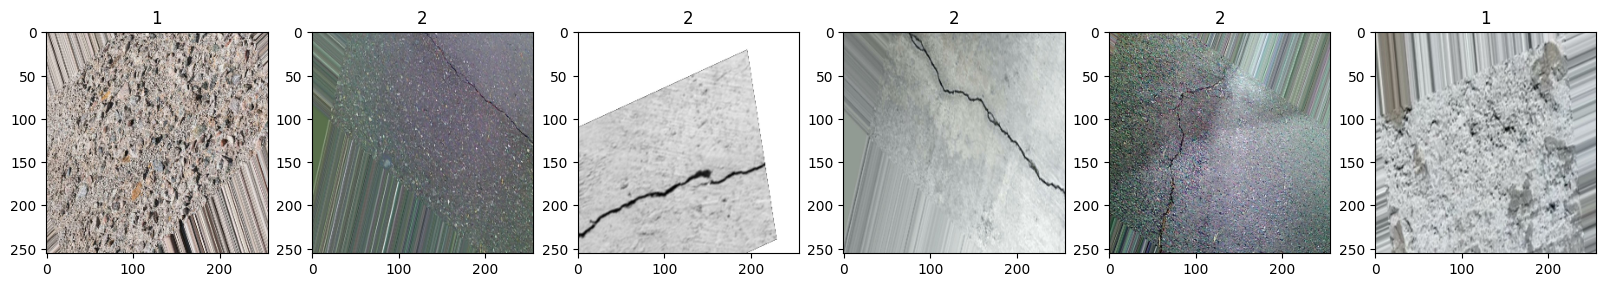

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 20))
for idx, img in enumerate(crack_batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(crack_batch[1][idx])

##Scale the image data

In [ ]:
crack_batch[0].min()

0.0

In [ ]:
crack_batch[0].max()

255.0

In [ ]:
scaled_crack= crack_batch[0]/255    #scaled from 0 to 1
scaled_crack.max()

1.0

In [ ]:
crack_data = crack_data.map(lambda x,y: (x/255,y))

In [ ]:
crack_scaled_iterator = crack_data.as_numpy_iterator()

In [ ]:
crack_batch = crack_scaled_iterator.next()

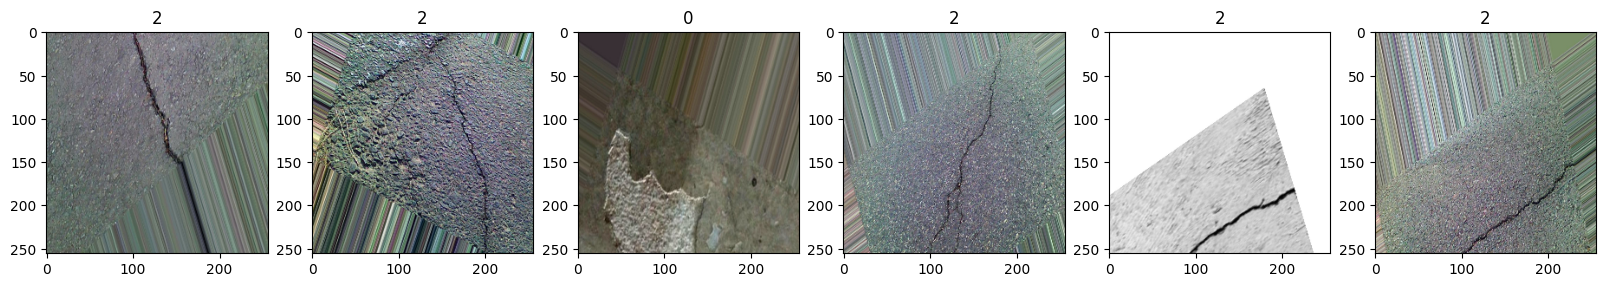

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 20))
for idx, img in enumerate(crack_batch[0][:6]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(crack_batch[1][idx])

##Split the images into training and testing sets

In [ ]:
len(crack_data)

208

In [ ]:
train_size2 = int(len(crack_data)*.7)
val_size2 = int(len(crack_data)*.2) +1 #evaluation of model
test_size2 = int(len(crack_data)*.1) + 1 #testing model
print(train_size2, val_size2, test_size2)

145 42 21


In [ ]:
train_data2 = crack_data.take(train_size2)
val_data2 = crack_data.skip(train_size2).take(val_size2)
test_data2= crack_data.skip(train_size2 + val_size2).take(test_size2)

##Developing InceptionV3 model

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Conv2D

In [ ]:
base_model = InceptionV3(
                         input_shape=(256,256,3),
                          weights='imagenet',
                          include_top=False)

#Freeze the first 10 layers
for layer in base_model.layers[:10]:
      layer.trainable =False


x=base_model.output

#x=Conv2D(128,3,3),activation='relu')(x)


#on the top of the model we add  the layers below:
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x=Dropout(0.3)(x)

predictions=Dense(3,activation='sigmoid')(x)  # 3 neurons - because we have 3 classes (spalling, delamination, surface_crack)

model2=Model(inputs=base_model.inputs, outputs=predictions)

87910968/87910968 [==============================] - 3s 0us/step


##Compiling MODEL2

In [ ]:
model2.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

##Fitting MODEL2

In [ ]:
history2=model2.fit(
    train_data2,
    validation_data=val_data2,
    epochs=150,
    verbose=1
)

Epoch 1/150
145/145 [==============================] - 331s 2s/step - loss: 0.3263 - accuracy: 0.8825 - val_loss: 2.5360 - val_accuracy: 0.7470
Epoch 2/150
145/145 [==============================] - 26s 177ms/step - loss: 0.1410 - accuracy: 0.9506 - val_loss: 3.0788 - val_accuracy: 0.7493
Epoch 3/150
145/145 [==============================] - 26s 177ms/step - loss: 0.1130 - accuracy: 0.9619 - val_loss: 0.2983 - val_accuracy: 0.9375
Epoch 4/150
145/145 [==============================] - 26s 174ms/step - loss: 0.1164 - accuracy: 0.9636 - val_loss: 0.2205 - val_accuracy: 0.9412
Epoch 5/150
145/145 [==============================] - 26s 175ms/step - loss: 0.0719 - accuracy: 0.9776 - val_loss: 0.1730 - val_accuracy: 0.9561
Epoch 6/150
145/145 [==============================] - 25s 172ms/step - loss: 0.0507 - accuracy: 0.9843 - val_loss: 0.1245 - val_accuracy: 0.9613
Epoch 7/150
145/145 [==============================] - 25s 172ms/step - loss: 0.0456 - accuracy: 0.9860 - val_loss: 0.6589 - v

##Plot performance

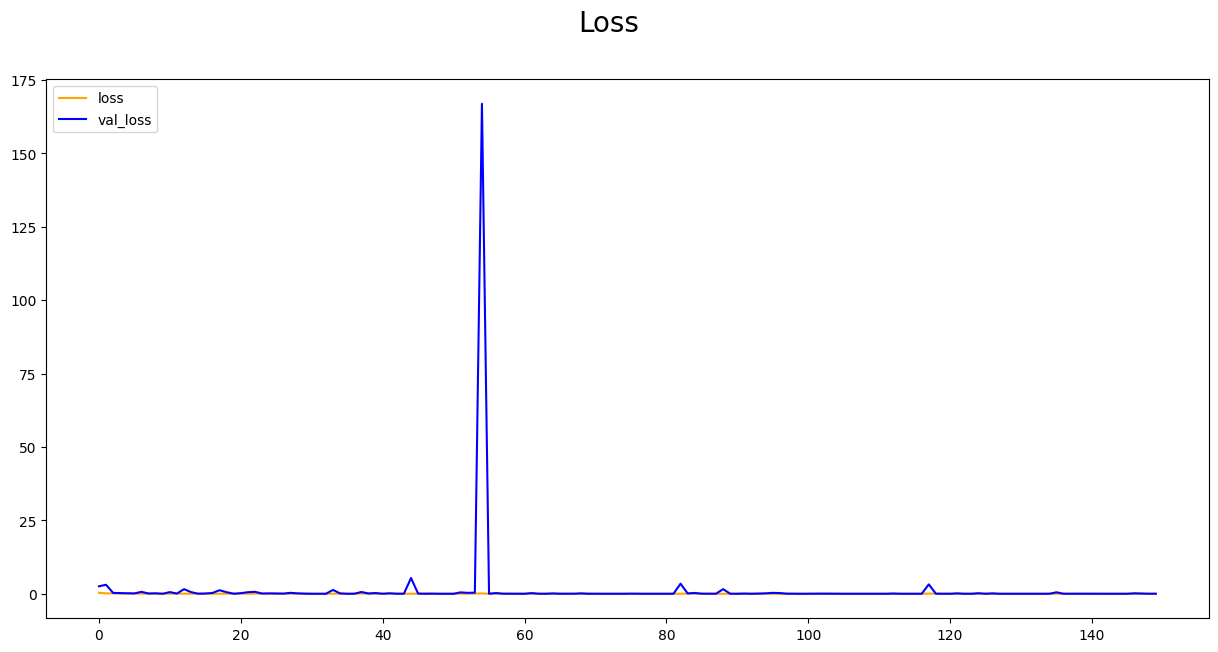

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(history2.history['loss'], color = 'orange', label = 'loss')
plt.plot(history2.history['val_loss'], color = 'blue', label = 'val_loss')
fig.suptitle ('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

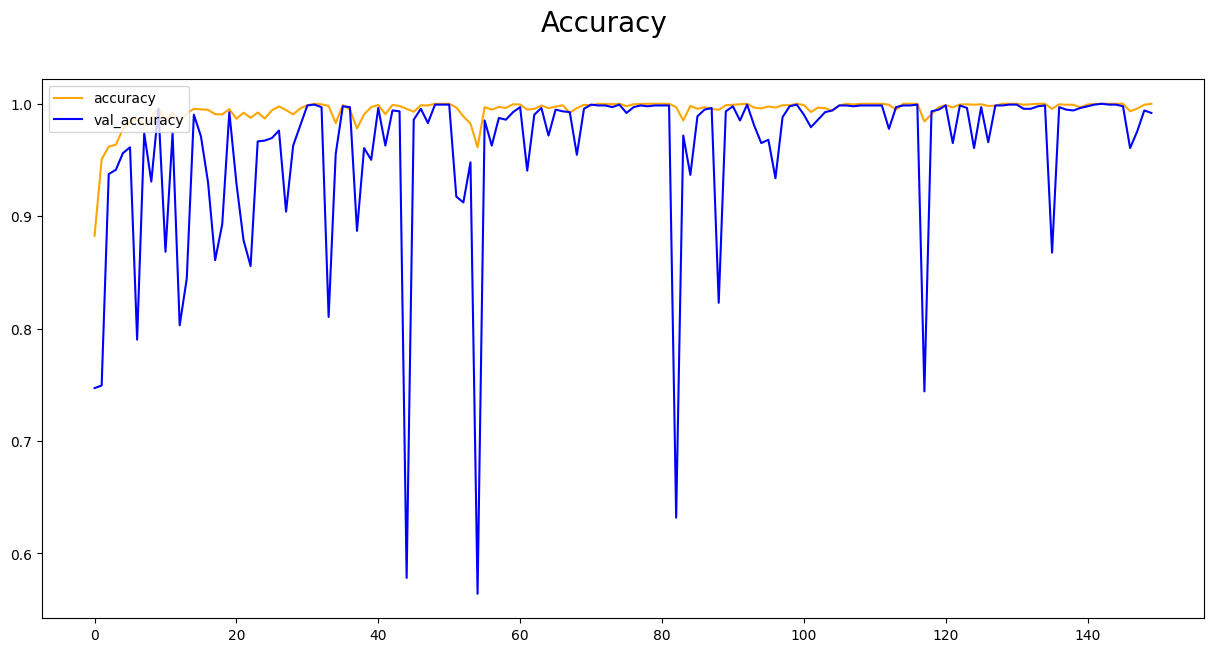

In [ ]:
fig = plt.figure(figsize=(15,7))
plt.plot(history2.history['accuracy'], color = 'orange', label = 'accuracy')
plt.plot(history2.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
fig.suptitle ('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

##Saving MODEL2

In [ ]:
model2.save('path/to/model')

#Loading back the trained models

In [ ]:
from keras.models import load_model

In [ ]:
m1= load_model('path/to/model1')

In [ ]:
m2= load_model('path/to/model2')

#Evaluate performance of hierarchical classification

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, Accuracy

In [ ]:
precision1 = Precision()
recall1 = Recall()
accuracy1 = BinaryAccuracy()

In [ ]:
precision2 = Precision()
recall2 = Recall()
accuracy2 = Accuracy()

In [ ]:
# Iterate over test_data
for batch in test_data1.as_numpy_iterator():
    X, y = batch  # Unpack the batch
    yhat1 = m1.predict(X)  # Predict with the first model
    yhat1_class = np.argmax(yhat1, axis=-1)

    # Update metrics for the first model
    precision1.update_state(y, yhat1_class)
    recall1.update_state(y, yhat1_class)
    accuracy1.update_state(y, yhat1_class)

    # Find the indices where the first model predicted 'crack'
    crack_indices = np.where(yhat1_class == 1)[0]

    if len(crack_indices) > 0:
        # If there are any 'crack' predictions, pass those images to the second model
        X_crack = X[crack_indices]
        y_crack = y[crack_indices]

        yhat2 = m2.predict(X_crack)
        yhat2_class = np.argmax(yhat2, axis=-1)

        # Update metrics for the second model
        precision2.update_state(y_crack, yhat2_class)
        recall2.update_state(y_crack, yhat2_class)
        accuracy2.update_state(y_crack, yhat2_class)

In [ ]:
# Print the final metric values for each model
print(f"Model 1 - Precision: {precision1.result().numpy()}, Recall: {recall1.result().numpy()}, Accuracy: {accuracy1.result().numpy()}")
print(f"Model 2 - Precision: {precision2.result().numpy()}, Recall: {recall2.result().numpy()}, Accuracy: {accuracy2.result().numpy()}")

#Test

In [ ]:
img = cv2.imread('path/to/test-image')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
# Check if yhat1 is within the range of class indices for the first model
yhat1=m1.predict(np.expand_dims(resize/255,0))
yhat1=np.argmax(yhat1)
if yhat1 ==1:
    print(f'no_crack')
elif yhat1==0:
    print(f'Crack')
    yhat2= m2.predict(np.expand_dims(resize/255,0))
    yhat2=np.argmax(yhat2)
    if yhat2 < 1:
        print(f'Delamination')
    elif yhat2 ==1:
        print("Spalling")
    else:
        print("Surface crack")
else:
    print("First level prediction out of range")

1/1 [==============================] - 0s 45ms/step
Crack
1/1 [==============================] - 0s 36ms/step
Delamination
